# Data Science Project

## Purpose
The goal of this data science project is to compute the Soil Organic Carbon (SOC) stock change by land cover class within a given region. The project will be implemented using a project-based learning approach, gradually buildind a Streamlit application as the final deliverable. The application will provide an interface to visualize and analyze the SOC stock change based on land cover types.

## Methodology
The steps to follow are described in the [Data Science Project repo](https://github.com/Vizzuality/sci_team_data_bank/wiki/Data-Science-Project).

## Setup
### Library import
We import all the required Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import netCDF4 as nc
import ee
import folium
from folium import plugins
from folium.plugins import Draw
import ipyleaflet as ipyl
from ipyleaflet import Map, TileLayer, basemaps, LayersControl, GeoJSON, LayerGroup, DrawControl
from ipywidgets import HTML, Output, interact
import json
import IPython.display as display
import zipfile
from urllib.request import urlopen
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import re
import pandas as pd
import glob


### Autenticate and Initialize Earth Engine

In [2]:
# ee.Authenticate()
ee.Initialize()

### Download the data from the [original source](http://maps.elie.ucl.ac.be/CCI/viewer/) and upload it to Google Earth Engine

#### 1. Convert NETCDF into GeoTIFF

**2000**

In [3]:
!gdalwarp -of Gtiff -co COMPRESS=LZW -co TILED=YES -ot Byte -te -180.0000000 -90.0000000 180.0000000 90.0000000 -tr 0.002777777777778 0.002777777777778 -t_srs EPSG:4326 NETCDF:/Users/sofia/Documents/Repos/SciVizz_project/data/raw/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc:lccs_class /Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2000.tif

Creating output file that is 129600P x 64800L.
Processing NETCDF:/Users/sofia/Documents/Repos/data_science_project/data/raw/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc:lccs_class [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


**2018**

In [4]:
!gdalwarp -of Gtiff -co COMPRESS=LZW -co TILED=YES -ot Byte -te -180.0000000 -90.0000000 180.0000000 90.0000000 -tr 0.002777777777778 0.002777777777778 -t_srs EPSG:4326 NETCDF:/Users/sofia/Documents/Repos/SciVizz_project/data/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc:lccs_class /Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2018.tif

Creating output file that is 129600P x 64800L.
Processing NETCDF:/Users/sofia/Documents/Repos/data_science_project/data/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc:lccs_class [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


#### 2. Create the image collection

In [5]:
!earthengine create collection projects/ee-sofiaaldabet-training/assets/landcover

Asset projects/ee-sofiaaldabet-training/assets/landcover already exists.


#### 3. Upload files to GEE

**NOTE:** 

This code is not working because we cannot upload files from local, they have to be stored in a bucket in Google Cloud Storage. Upload them manually in GEE.

In [26]:
# # Upload the GeoTIFF files to Earth Engine
# !earthengine upload image --asset_id=projects/training-vizzproject/assets/landcover/lc2000 --nodata_value=0 --pyramiding_policy=mean --bands=band1 /Users/sofia/Documents/Training/Data-Science-Project/landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.tif
# !earthengine upload image --asset_id=projects/training-vizzproject/assets/landcover/lc2018 --nodata_value=0 --pyramiding_policy=mean --bands=band1 /Users/sofia/Documents/Training/Data-Science-Project/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.tif

Invalid Cloud Storage URL: /Users/sofia/Library/CloudStorage/GoogleDrive-sofia.aldabet@vizzuality.com/My


## Data processing

### Visualize layers in ipyleaflet:

* Calculate SOC change
* Represent the land cover layers for 2000 and 2018
* Allow drawing a custom area of interest

In [6]:
# Load the SOC stock image collection
socStockCollection = ee.ImageCollection('projects/soils-revealed/Recent/SOC_stock_nov2020')

# Sort the collection by 'system:time_start' property in ascending order
sortedCollection = socStockCollection.sort('system:time_start')

# Select the first and last images in the sorted collection
firstImage = sortedCollection.first()
lastImage = sortedCollection.sort('system:time_start', False).first()

# Calculate the difference between the first and last images
socStockChange = lastImage.subtract(firstImage)

# Define the color ramp
colorRamp = [
    '#B30200',  # -10
    '#E34A33',  # -7.5
    '#FC8D59',  # -5
    '#FDCC8A',  # -2.5
    '#FFFFCC',  # 0
    '#A1DAB4',  # 2.5
    '#31B3BD',  # 5
    '#1C9099',  # 7.5
    '#066C59'   # 10
]

# Define the visualization parameters
visParams = {
    'min': -10,
    'max': 10,
    'palette': colorRamp
}

# Create a map centered on the collection
center = (42, -8)  # Latitude, Longitude of Spain
zoom = 7 # Zoom level for the map
m = Map(center=center, zoom=zoom)

# Add the SOC stock change layer as a tile layer
socStockChange_tile = TileLayer(
    url=socStockChange.getMapId(visParams)['tile_fetcher'].url_format,
    attribution='Google Earth Engine',
    name='SOC Stock Change',
    opacity=1.0
)
m.add_layer(socStockChange_tile)

# Select two images from the collection
lc1 = ee.Image(ee.ImageCollection('projects/ee-sofiaaldabet-training/assets/landcover')
               .filterDate('2000-01-01', '2000-12-31').first())
lc2 = ee.Image(ee.ImageCollection('projects/ee-sofiaaldabet-training/assets/landcover')
               .filterDate('2018-01-01', '2018-12-31').first())

sld_ramp = '''
<RasterSymbolizer>
  <ColorMap type="ramp" extended="false">
    <ColorMapEntry color="#5b5b18" quantity="10" label="Cropland rainfed" />
    <ColorMapEntry color="#7d7617" quantity="11" label="Cropland rainfed herbaceous" />
    <ColorMapEntry color="#124d00" quantity="12" label="Cropland rainfed tree or shrub" />
    <ColorMapEntry color="#a09113" quantity="20" label="Cropland irrigation or post-flood" />
    <ColorMapEntry color="#c0ab10" quantity="30" label="Mosaic cropland" />
    <ColorMapEntry color="#dfc30c" quantity="40" label="Mosaic natural vegetation" />
    <ColorMapEntry color="#136010" quantity="50" label="Tree broadleaved evergreen closed to open" />
    <ColorMapEntry color="#117221" quantity="60" label="Tree broadleaved decidious closed to open" />
    <ColorMapEntry color="#0b842f" quantity="61" label="Tree broadleaved decidious closed" />
    <ColorMapEntry color="#2a9339" quantity="62" label="Tree broadleaved decidious open" />
    <ColorMapEntry color="#4aa040" quantity="70" label="Tree needle evergreen closed to open" />
    <ColorMapEntry color="#91c357" quantity="80" label="Tree needle decidious closed to open" />
    <ColorMapEntry color="#a5ce5f" quantity="81" label="Tree needle decidious closed" />
    <ColorMapEntry color="#b9d867" quantity="82" label="Tree needle decidious open" />
    <ColorMapEntry color="#cce36f" quantity="90" label="Tree mixed" />
    <ColorMapEntry color="#e0ed78" quantity="100" label="Mosaic tree and shrubland" />
    <ColorMapEntry color="#967216" quantity="110" label="Mosaic herbaceous" />
    <ColorMapEntry color="#a67d1a" quantity="120" label="Shrubland" />
    <ColorMapEntry color="#b6881f" quantity="121" label="Shrubland evergreen" />
    <ColorMapEntry color="#c69323" quantity="122" label="Shrubland decidious" />
    <ColorMapEntry color="#d69e27" quantity="130" label="Grassland" />
    <ColorMapEntry color="#e6a82b" quantity="140" label="Lichens and mosses" />
    <ColorMapEntry color="#f6b148" quantity="150" label="Sparse vegetation" />
    <ColorMapEntry color="#febc7a" quantity="151" label="Sparse tree" />
    <ColorMapEntry color="#ffcaaa" quantity="152" label="Sparse shrub" />
    <ColorMapEntry color="#f8dcd3" quantity="153" label="Sparse herbaceous" />
    <ColorMapEntry color="#016a6d" quantity="160" label="Tree cover flooded fresh or brackish water" />
    <ColorMapEntry color="#42ded5" quantity="170" label="Tree cover flooded saline water" />
    <ColorMapEntry color="#35adad" quantity="180" label="Shrub or herb cover flood" />
    <ColorMapEntry color="#3640b7" quantity="190" label="Urban" />
    <ColorMapEntry color="#df704f" quantity="200" label="Bare areas" />
    <ColorMapEntry color="#c54802" quantity="201" label="Bare areas consolidated" />
    <ColorMapEntry color="#fd9ca7" quantity="202" label="Bare areas unconsolidated" />
    <ColorMapEntry color="#48a7ff" quantity="210" label="Water bodies" />
    <ColorMapEntry color="#b9eeef" quantity="220" label="Snow and ice" />
  </ColorMap>
</RasterSymbolizer>
'''

# Add and display the landcover images
lc1_tile = TileLayer(
    url=lc1.sldStyle(sld_ramp).getMapId()['tile_fetcher'].url_format,
    attribution='Google Earth Engine',
    name='Landcover 2000',
    opacity=1.0
)
m.add_layer(lc1_tile)

lc2_tile = TileLayer(
    url=lc2.sldStyle(sld_ramp).getMapId()['tile_fetcher'].url_format,
    attribution='Google Earth Engine',
    name='Landcover 2018',
    opacity=1.0
)
m.add_layer(lc2_tile)

# Custom polygon and rectangle styles
polygon_style = {'color': 'black', 'weight': 4, 'fillOpacity': 0}
rectangle_style = {'color': 'red', 'weight': 4, 'fillOpacity': 0}

# Add a drawing control to the map with only polygon and rectangle options
draw_control = DrawControl(
    polygon={'shapeOptions': polygon_style},
    rectangle={'shapeOptions': rectangle_style},
    edit=False,
    remove=True,
    draw={'polygon': {'allowIntersection': False}}
)
m.add_control(draw_control)

# List to store the drawn geometries as GeoJSON objects
drawn_geometries = []

# Function to handle drawing events
def handle_draw(event, action, geo_json):
    if action == 'created':
        drawn_geometries.append(geo_json)
    elif action == 'deleted':
        for drawn_geometry in drawn_geometries:
            if drawn_geometry['id'] == event['id']:
                drawn_geometries.remove(drawn_geometry)

    # Save the drawn geometries as a GeoJSON file
    with open('../data/raw/drawn_geometries.geojson', 'w') as f:
        json.dump(drawn_geometries, f)

# Bind the drawing event to the handle_draw function
draw_control.on_draw(handle_draw)

# Set the basemap to a default option
m.add_layer(basemaps.OpenStreetMap)

# Create layer controls
layer_control = LayersControl(position='topright')

# Add the layer control widget to the map
m.add_control(layer_control)

# Display the map
m


Map(center=[42, -8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Draw a custom geometry in the map above and calculate the % of each land cover in your area of interest

In [18]:
# Convert drawn_geometries to an Earth Engine FeatureCollection
geometry_collection = ee.FeatureCollection(ee.FeatureCollection(drawn_geometries))

# Select lc2 image for the specified date range
lc2 = ee.Image(ee.ImageCollection('projects/ee-sofiaaldabet-training/assets/landcover')
               .filterDate('2018-01-01', '2018-12-31').first())

# Clip lc2 using the geometry_collection
lc2_clipped = lc2.clip(geometry_collection)

# Calculate the frequency histogram of land cover classes in the clipped image
lc2_histogram = lc2_clipped.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=geometry_collection.geometry(),  # Use the custom geometry as ROI
    scale=30  # Resolution in meters
)


# Dictionary to store land cover class names and colors
landcover_info = {
    '10': {'Landcover': 'Cropland rainfed', 'Color': '#5b5b18'},
    '11': {'Landcover': 'Cropland rainfed herbaceous', 'Color': '#7d7617'},
    '12': {'Landcover': 'Cropland rainfed tree or shrub', 'Color': '#124d00'},
    '20': {'Landcover': 'Cropland irrigation or post-flood', 'Color': '#a09113'},
    '30': {'Landcover': 'Mosaic cropland', 'Color': '#c0ab10'},
    '40': {'Landcover': 'Mosaic natural vegetation', 'Color': '#dfc30c'},
    '50': {'Landcover': 'Tree broadleaved evergreen closed to open', 'Color': '#136010'},
    '60': {'Landcover': 'Tree broadleaved deciduous closed to open', 'Color': '#117221'},
    '61': {'Landcover': 'Tree broadleaved deciduous closed', 'Color': '#0b842f'},
    '62': {'Landcover': 'Tree broadleaved deciduous open', 'Color': '#2a9339'},
    '70': {'Landcover': 'Tree needle evergreen closed to open', 'Color': '#4aa040'},
    '80': {'Landcover': 'Tree needle deciduous closed to open', 'Color': '#91c357'},
    '81': {'Landcover': 'Tree needle deciduous closed', 'Color': '#a5ce5f'},
    '82': {'Landcover': 'Tree needle deciduous open', 'Color': '#b9d867'},
    '90': {'Landcover': 'Tree mixed', 'Color': '#cce36f'},
    '100': {'Landcover': 'Mosaic tree and shrubland', 'Color': '#e0ed78'},
    '110': {'Landcover': 'Mosaic herbaceous', 'Color': '#967216'},
    '120': {'Landcover': 'Shrubland', 'Color': '#a67d1a'},
    '121': {'Landcover': 'Shrubland evergreen', 'Color': '#b6881f'},
    '122': {'Landcover': 'Shrubland deciduous', 'Color': '#c69323'},
    '130': {'Landcover': 'Grassland', 'Color': '#d69e27'},
    '140': {'Landcover': 'Lichens and mosses', 'Color': '#e6a82b'},
    '150': {'Landcover': 'Sparse vegetation', 'Color': '#f6b148'},
    '151': {'Landcover': 'Sparse tree', 'Color': '#febc7a'},
    '152': {'Landcover': 'Sparse shrub', 'Color': '#ffcaaa'},
    '153': {'Landcover': 'Sparse herbaceous', 'Color': '#f8dcd3'},
    '160': {'Landcover': 'Tree cover flooded fresh or brackish water', 'Color': '#016a6d'},
    '170': {'Landcover': 'Tree cover flooded saline water', 'Color': '#42ded5'},
    '180': {'Landcover': 'Shrub or herb cover flood', 'Color': '#35adad'},
    '190': {'Landcover': 'Urban', 'Color': '#3640b7'},
    '200': {'Landcover': 'Bare areas', 'Color': '#df704f'},
    '201': {'Landcover': 'Bare areas consolidated', 'Color': '#c54802'},
    '202': {'Landcover': 'Bare areas unconsolidated', 'Color': '#fd9ca7'},
    '210': {'Landcover': 'Water bodies', 'Color': '#48a7ff'},
    '220': {'Landcover': 'Snow and ice', 'Color': '#b9eeef'}
}


# Create a DataFrame to store the land cover class information
landcover_df = pd.DataFrame.from_dict(landcover_info, orient='index')

# Get the landcover class values and their respective counts
lc2_counts = lc2_histogram.get('b1').getInfo()

# Calculate the total count of land cover classes
total_count = sum(lc2_counts.values())

# Calculate the percentage of each land cover class
percentage_landcover = {}
for landcover, count in lc2_counts.items():
    percentage = round((count / total_count) * 100, 1)
    label = landcover_info[landcover]['Landcover']
    color = landcover_info[landcover]['Color']
    percentage_landcover[label] = {'Value': landcover, 'Landcover': label, 'Color': color, 'Percentage': percentage}

# Create a DataFrame from the percentage_landcover dictionary
landcover_df = pd.DataFrame(list(percentage_landcover.values()))

# Remove rows that have a percentage of 0
landcover_df = landcover_df[landcover_df['Percentage'] != 0]

# Display the DataFrame
landcover_df



,Value,Landcover,Color,Percentage
0,10,Cropland rainfed,#5b5b18,7.3
1,100,Mosaic tree and shrubland,#e0ed78,7.0
2,11,Cropland rainfed herbaceous,#7d7617,2.2
5,130,Grassland,#d69e27,6.6
7,190,Urban,#3640b7,1.3
8,20,Cropland irrigation or post-flood,#a09113,0.2
11,210,Water bodies,#48a7ff,17.3
12,30,Mosaic cropland,#c0ab10,8.8
13,40,Mosaic natural vegetation,#dfc30c,12.7
14,60,Tree broadleaved deciduous closed to open,#117221,35.2


### Visualize the computed distribution of land cover classes in percentages using matplotlib

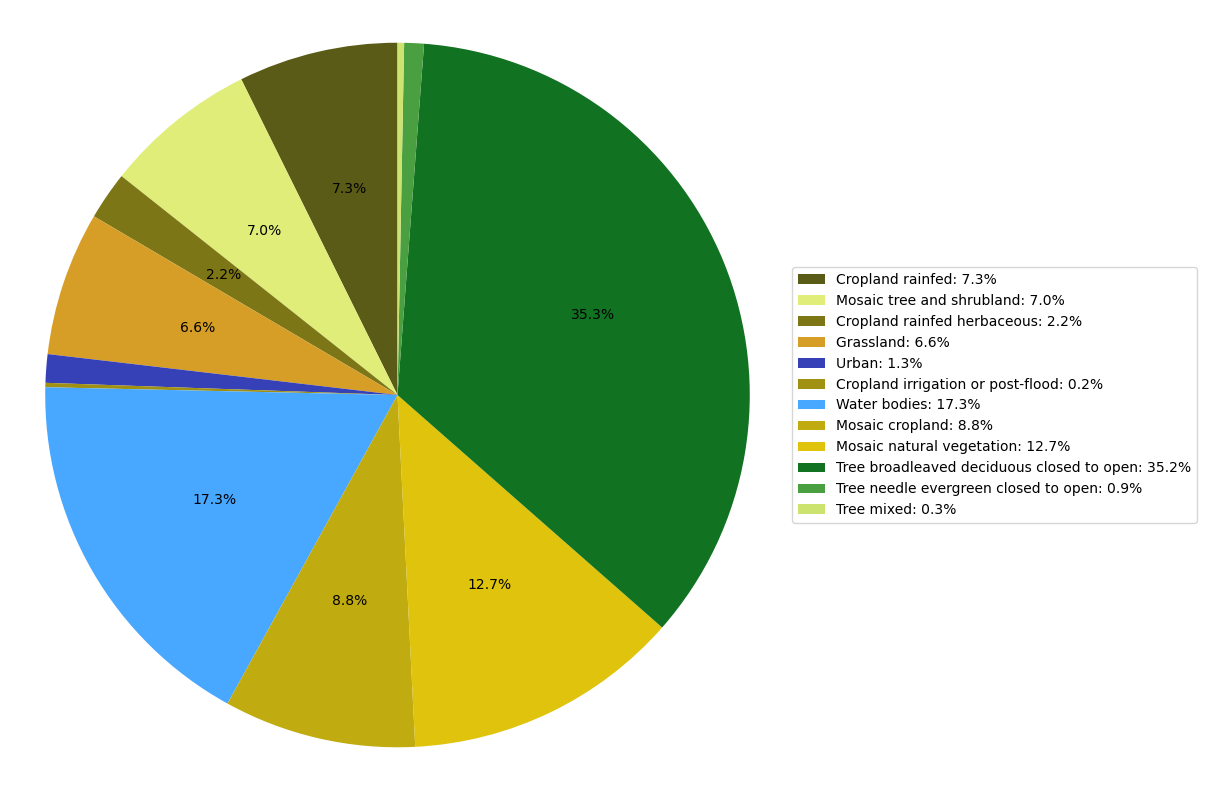

In [19]:
# Plot the results in a pie chart
threshold = 2  # Hide labels for slices below 2%

fig, ax = plt.subplots(figsize=(10, 10))
wedges, _, autotexts = ax.pie(landcover_df['Percentage'], labels=[""] * len(landcover_df['Landcover']), colors=landcover_df['Color'], autopct=lambda pct: f"{pct:.1f}%" if pct > threshold else '', startangle=90, textprops={'color': 'k'})  # Set labels to empty
ax.axis('equal')

# Create the legend labels with both category name and percentage
legend_labels = [f"{label}: {pct:.1f}%" for label, pct in zip(landcover_df['Landcover'], landcover_df['Percentage'])]
ax.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the label font size for better readability
for autotext in autotexts:
    autotext.set_fontsize(10)

plt.show()



-----------------------------------
### Try a different method:

* Instead of drawing the geometry on the map use create a geojson
* Calculate SOC change and visualize all layers using Folium
* Create a geometry and use it to clip the land cover
* Save and load the clipped image as a tif file
* Calculate statistics and visualize the results in a pie chart



#### Create an area of interest and save it as GeoJSON

In [20]:
# Define area of interest and create GeoJSON data
geojson_aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -8.274649167282945,
              43.56804663141648
            ],
            [
              -8.274649167282945,
              43.18742441852072
            ],
            [
              -7.673586113822324,
              43.18742441852072
            ],
            [
              -7.673586113822324,
              43.56804663141648
            ],
            [
              -8.274649167282945,
              43.56804663141648
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Save as GeoJSON file
file_path = "/Users/sofia/Documents/Repos/SciVizz_project/data/raw/aoi_custom.geojson"

with open(file_path, "w") as f:
    json.dump(geojson_aoi, f)

#### Visualize layers in Folium


In [22]:
# Load the SOC stock image collection
socStockCollection = ee.ImageCollection('projects/soils-revealed/Recent/SOC_stock_nov2020')

# Sort the collection by 'system:time_start' property in ascending order
sortedCollection = socStockCollection.sort('system:time_start')

# Select the first and last images in the sorted collection
firstImage = sortedCollection.first()
lastImage = sortedCollection.sort('system:time_start', False).first()

# Calculate the difference between the first and last images
socStockChange = lastImage.subtract(firstImage)

# Define the color ramp
colorRamp = [
    '#B30200',  # -10
    '#E34A33',  # -7.5
    '#FC8D59',  # -5
    '#FDCC8A',  # -2.5
    '#FFFFCC',  # 0
    '#A1DAB4',  # 2.5
    '#31B3BD',  # 5
    '#1C9099',  # 7.5
    '#066C59'   # 10
]

# Define the visualization parameters
visParams = {
    'min': -10,
    'max': 10,
    'palette': colorRamp
}

# Create a folium map centered on the collection
Map = folium.Map(location=[42, -8], zoom_start=7)

# Add the SOC stock change layer as an image overlay
Map.add_child(folium.TileLayer(
    tiles=socStockChange.getMapId({'min': -10, 'max': 10, 'palette': colorRamp})['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='SOC Stock Change',
    overlay=True,
    control=True
))

# Select two images from the collection
lc1 = ee.Image(ee.ImageCollection('projects/ee-sofiaaldabet-training/assets/landcover')
               .filterDate('2000-01-01', '2000-12-31').first())
lc2 = ee.Image(ee.ImageCollection('projects/ee-sofiaaldabet-training/assets/landcover')
               .filterDate('2018-01-01', '2018-12-31').first())

sld_ramp = '''
<RasterSymbolizer>
  <ColorMap type="ramp" extended="false">
    <ColorMapEntry color="#5b5b18" quantity="10" label="Cropland rainfed" />
    <ColorMapEntry color="#7d7617" quantity="11" label="Cropland rainfed herbaceous" />
    <ColorMapEntry color="#124d00" quantity="12" label="Cropland rainfed tree or shrub" />
    <ColorMapEntry color="#a09113" quantity="20" label="Cropland irrigation or post-flood" />
    <ColorMapEntry color="#c0ab10" quantity="30" label="Mosaic cropland" />
    <ColorMapEntry color="#dfc30c" quantity="40" label="Mosaic natural vegetation" />
    <ColorMapEntry color="#136010" quantity="50" label="Tree broadleaved evergreen closed to open" />
    <ColorMapEntry color="#117221" quantity="60" label="Tree broadleaved decidious closed to open" />
    <ColorMapEntry color="#0b842f" quantity="61" label="Tree broadleaved decidious closed" />
    <ColorMapEntry color="#2a9339" quantity="62" label="Tree broadleaved decidious open" />
    <ColorMapEntry color="#4aa040" quantity="70" label="Tree needs everg clod to open" />
    <ColorMapEntry color="#91c357" quantity="80" label="Tree needle decidious closed to open" />
    <ColorMapEntry color="#a5ce5f" quantity="81" label="Tree needle decidious closed" />
    <ColorMapEntry color="#b9d867" quantity="82" label="Tree needle decidious open" />
    <ColorMapEntry color="#cce36f" quantity="90" label="Tree mixed" />
    <ColorMapEntry color="#e0ed78" quantity="100" label="Mosaic tree and shrubland" />
    <ColorMapEntry color="#967216" quantity="110" label="Mosaic herbaceous" />
    <ColorMapEntry color="#a67d1a" quantity="120" label="Shrubland" />
    <ColorMapEntry color="#b6881f" quantity="121" label="Shrubland evergreen" />
    <ColorMapEntry color="#c69323" quantity="122" label="Shrubland decidious" />
    <ColorMapEntry color="#d69e27" quantity="130" label="Grassland" />
    <ColorMapEntry color="#e6a82b" quantity="140" label="Lichens and mosses" />
    <ColorMapEntry color="#f6b148" quantity="150" label="Sparse vegetation" />
    <ColorMapEntry color="#febc7a" quantity="151" label="Sparse tree" />
    <ColorMapEntry color="#ffcaaa" quantity="152" label="Sparse shrub" />
    <ColorMapEntry color="#f8dcd3" quantity="153" label="Sparse herbaceous" />
    <ColorMapEntry color="#016a6d" quantity="160" label="Tree cover flooded fresh or brackish water" />
    <ColorMapEntry color="#42ded5" quantity="170" label="Tree cover flooded saline water" />
    <ColorMapEntry color="#35adad" quantity="180" label="Shrub or herb cover flood" />
    <ColorMapEntry color="#3640b7" quantity="190" label="Urban" />
    <ColorMapEntry color="#df704f" quantity="200" label="Bare areas" />
    <ColorMapEntry color="#c54802" quantity="201" label="Bare areas consolidated" />
    <ColorMapEntry color="#fd9ca7" quantity="202" label="Bare areas unconsolidated" />
    <ColorMapEntry color="#48a7ff" quantity="210" label="Water bodies" />
    <ColorMapEntry color="#b9eeef" quantity="220" label="Snow and ice" />
  </ColorMap>
</RasterSymbolizer>
'''

# Add and display the landcover images
Map.add_child(folium.TileLayer(
    tiles=lc1.sldStyle(sld_ramp).getMapId()['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Landcover 2000',
    overlay=True,
    control=True
))

Map.add_child(folium.TileLayer(
    tiles=lc2.sldStyle(sld_ramp).getMapId()['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='Landcover 2018',
    overlay=True,
    control=True
))

# Load the GeoJSON data from a file
with open('/Users/sofia/Documents/Repos/SciVizz_project/data/raw/aoi_custom.geojson') as f:
    geojson_data = json.load(f)

# Get the geometry from the GeoJSON
geometry = geojson_data['features'][0]['geometry']

# Convert the geometry to an Earth Engine object
ee_geometry = ee.Geometry(geometry)

# Create an Earth Engine layer from the geometry
ee_layer = ee.Image().paint(ee_geometry, 0, 1)

# Create a folium layer from the Earth Engine layer
folium_layer = folium.TileLayer(
    tiles=ee_layer.getMapId()['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    name='GeoJSON Geometry',
    overlay=True,
    control=True
)

# Add the folium layer to the map
Map.add_child(folium_layer)

# Add a layer control panel to the map
Map.add_child(folium.LayerControl())

# Display the map
Map

#### Use the geojson to clip the landcover layer and display the resulting image

In [23]:
# Load the GeoJSON file
with open(file_path) as f:
    aoi = json.load(f)

# Convert it to ee.Geometry()
aoi = ee.Geometry.Polygon(geojson_aoi["features"][0]["geometry"]["coordinates"])

# Clip the landcover image 2018 to the area of interest
aoi_image = ee.Image(lc2).clip(ee.Geometry(aoi))

In [24]:
# Show the clipped image
def show_image(image):
    thumbnail_url = image.getThumbUrl({
        'min': 10,
        'max': 220,
        'dimensions': '500'
    })
    display.display(display.Image(url=thumbnail_url))

show_image(aoi_image)

#### Download the clipped image in case it's needed later

In [32]:
# Download the clipped image as a tif file

def download_image(image):
    
    download_zip = '/Users/sofia/Documents/Repos/SciVizz_project/data/raw/data.zip'
    
    url = image.getDownloadUrl()     

    print('Downloading image...')
    print("url: ", url)
    data = urlopen(url)
    with open(download_zip, 'wb') as fp:
        while True:
            chunk = data.read(16 * 1024)
            if not chunk: break
            fp.write(chunk)
            
    # extract the zip file transformation data
    z = zipfile.ZipFile(download_zip, 'r')
    target_folder_name = download_zip.split('.zip')[0]
    z.extractall(target_folder_name)
    # remove directory
    os.remove(download_zip)
    print('Download complete!')

download_image(aoi_image)

url:  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88fe9cd39c7b49baa6defb36865b08e0-15d62b25047ed8e0b9cae46c84964c62:getPixels
Download complete!


#### Import the AOI landcover and visualize it with the corresponding colors

In [33]:
# Load the TIFF file data
tif_file_path = glob.glob('/Users/sofia/Documents/Repos/SciVizz_project/data/raw/data/*.tif')[0]  # Assuming only one TIFF file exists in the './data/' directory

with rasterio.open(tif_file_path) as src:
    data = src.read()
    profile = src.profile
    transform = src.transform

/var/folders/98/0pdnjc5s29x2pnzl293pw7hr0000gn/T/ipykernel_9208/578307732.py:9: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -9999 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  data[np.isnan(data)] = -9999


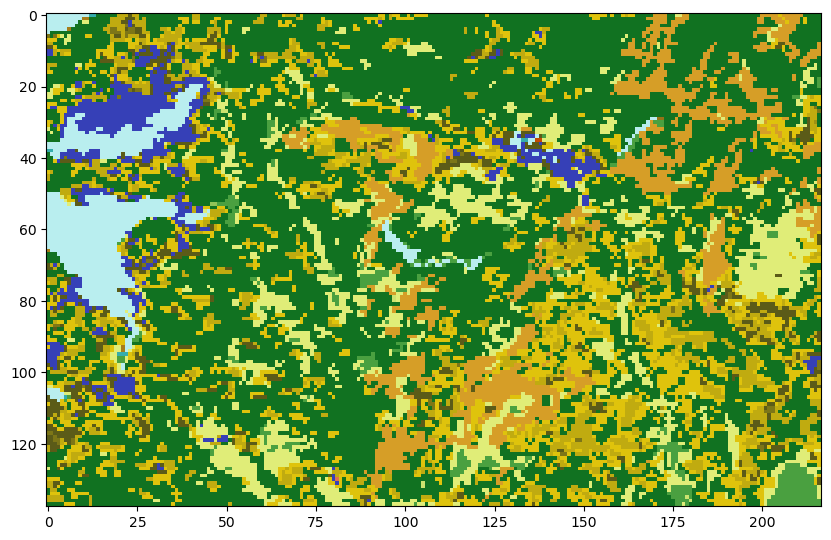

In [34]:
# Extract color and quantity information from sld_ramp
entries = re.findall(r'<ColorMapEntry color="(.*?)" quantity="(.*?)" label="(.*?)"', sld_ramp)

# Create a list of colors and quantities
sld_colors = [entry[0] for entry in entries]
sld_quantities = [float(entry[1]) for entry in entries]

# Replace NaN values with a specific value (e.g., -9999)
data[np.isnan(data)] = -9999

# Create a custom colormap from the color and quantity information
cmap = mcolors.ListedColormap(sld_colors)
norm = mcolors.BoundaryNorm(sld_quantities, len(sld_colors))

# Plot the image with the custom colormap and norm
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(data[0, :, :], cmap=cmap, norm=norm, interpolation='none')

# Show the plot
plt.show()

#### Compute the distribution of land cover classes in percentages

In [36]:
# Create a list of color, label, and quantity tuples
land_use_classes = [(color, label, float(quantity)) for color, quantity, label in entries]

# Create an empty list to store the results
results = []

# Calculate the total number of pixels in the image
total_pixels = data.size

# Calculate the percentage for each land use class
for color, land_use_class, land_use_value in land_use_classes:
    # Create a mask for the land use class
    land_use_mask = (data == land_use_value)

    # Calculate the number of pixels for the land use class
    land_use_pixels = np.count_nonzero(land_use_mask)

    # Calculate the percentage of the land use class and round to 1 decimal
    percentage = round((land_use_pixels / total_pixels) * 100, 1)

    # Save the results for land use classes with a percentage greater than 0
    if percentage > 0:
        results.append({'land_use_class': land_use_class, 'percentage': percentage, 'color': color})

# Create a DataFrame from the results list
df = pd.DataFrame(results)

# Display the dataframe
df


,land_use_class,percentage,color
0,Cropland rainfed,3.3,#5b5b18
1,Cropland rainfed herbaceous,0.3,#7d7617
2,Mosaic cropland,7.2,#c0ab10
3,Mosaic natural vegetation,14.3,#dfc30c
4,Tree broadleaved decidious closed to open,49.0,#117221
5,Tree needs everg clod to open,1.7,#4aa040
6,Mosaic tree and shrubland,9.6,#e0ed78
7,Grassland,7.5,#d69e27
8,Urban,3.3,#3640b7
9,Water bodies,3.8,#48a7ff


#### Visualize the computed distribution of land cover classes in percentages using matplotlib

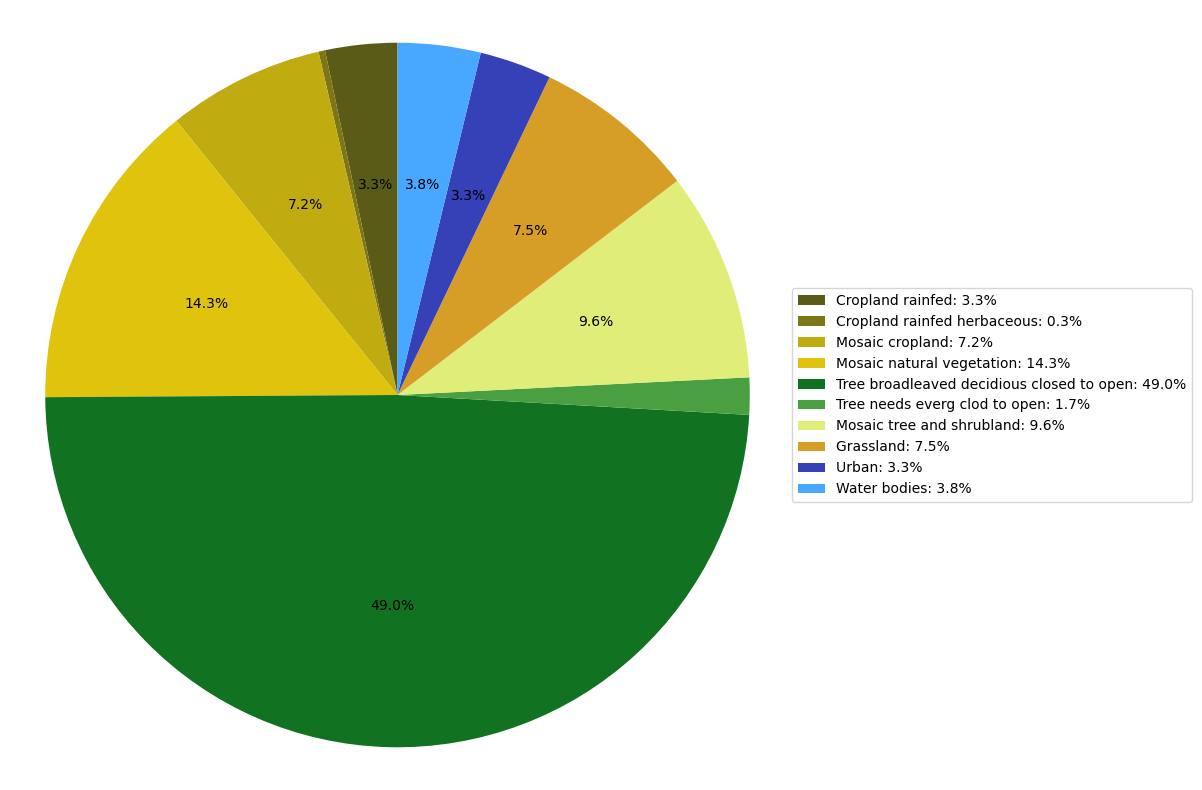

In [37]:
# Plot the results in a pie chart
threshold = 2  # Hide labels for slices below 2%

fig, ax = plt.subplots(figsize=(10, 10))
wedges, _, autotexts = ax.pie(df['percentage'], labels=[""] * len(df['land_use_class']), colors=df['color'], autopct=lambda pct: f"{pct:.1f}%" if pct > threshold else '', startangle=90, textprops={'color': 'k'})  # Set labels to empty
ax.axis('equal')

# Create the legend labels with both category name and percentage
legend_labels = [f"{label}: {pct:.1f}%" for label, pct in zip(df['land_use_class'], df['percentage'])]
ax.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the label font size for better readability
for autotext in autotexts:
    autotext.set_fontsize(10)

plt.show()

